In [ ]:
# !pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [2]:
from dotenv import load_dotenv
from time import sleep
import os
import json

load_dotenv()  # take environment variables from .env.

True

In [157]:
# establish a connection to the PostgreSQL database
import psycopg2 as pg

conn = pg.connect(
    dbname=os.environ["POSTGRES_DB_VECTOR"],
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"]
)

conn2 = pg.connect(
    dbname=os.environ["POSTGRES_DB"],
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"]
)

In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = "text-embedding-3-large"
dimensions = 256
embeddings = OpenAIEmbeddings(model=embeddings_model, dimensions=dimensions)

In [5]:
from langchain_postgres import PGVector
from langchain_postgres.vectorstores import PGVector, DistanceStrategy

# See docker command above to launch a postgres instance with pgvector enabled.
connection = f'postgresql+psycopg://{os.environ["POSTGRES_USER"]}:{os.environ["POSTGRES_PASSWORD"]}@{os.environ["POSTGRES_HOST"]}:5432/{os.environ["POSTGRES_DB_VECTOR"]}'  # Uses psycopg3!
collection_name = "all_properties"

# https://api.python.langchain.com/en/latest/vectorstores/langchain_postgres.vectorstores.PGVector.html

vector_store = PGVector(
    embeddings=embeddings,
    embedding_length=dimensions,
    distance_strategy=DistanceStrategy.COSINE,
    collection_name=collection_name,
    connection=connection,
    use_jsonb=True
)

In [ ]:
df = pd.read_sql_query(
    """
    SELECT
        embedding,
        cmetadata->>'property_id' as property_id,
        cmetadata->>'property_name' as property_name,
        cmetadata->>'property_description' as property_description,
        cmetadata->>'entity_class' as entity_class,
        cmetadata->>'entity_subclass' as entity_subclass,
        cmetadata->>'target_class' as target_class
    FROM langchain_pg_embedding WHERE collection_id = '9d70e7bc-099d-467c-a7e7-312345b411bd' LIMIT 1000;
    """, conn)

/tmp/ipykernel_284423/993173503.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [30]:
df.head()

,embedding,property_id,property_name,property_description,entity_class,entity_subclass,target_class
0,"[-0.005819867,0.07133708,-0.03466942,0.046991885,-0.0656088,0.07546677,-0.01654374,-0.074334435,0.033204045,-0.118162446,0.060779724,0.111634865,-0.10044474,-0.030073475,-0.045493208,-0.00024665744,-0.024611626,0.0647762,-0.056483515,0.02331277,0.05225391,0.07813109,-0.09205214,0.08525813,0.09618183,0.009849645,-0.026160259,0.0051454618,-0.045393296,-0.005520131,-0.00155696,-0.038299553,0.06680774,0.0043877964,0.025194444,-0.053219724,-0.026276823,-0.015577926,0.008109514,-0.04166325,0.08385937,-0.15945935,-0.14400631,0.0521873,0.14920174,0.034835942,-0.033637,-0.016610349,-0.08998729,-0.019632684,-0.014270746,0.010332553,-0.08858853,0.03282105,-0.011056914,0.014953477,0.004483545,-0.05688316,0.043395057,0.07186994,-0.14347345,-0.04849056,-0.0137462085,-0.055584308,-0.022313653,-0.07073761,0.014270746,0.077798046,-0.05864827,-0.06051329,0.0050455495,0.09285144,0.0959154,0.10390835,-0.023112947,0.09012051,-0.022180436,0.04149673,-0.017517881,0.01586101,0.037666775,-0.008442554,0.007947157,0.09131946,-0.1001117,0.02171418,0.0040610014,-0.1421413,-0.020964842,0.0029203407,-0.07033796,-0.06827311,-0.025694003,-0.03255462,-0.011414932,-0.038332857,0.09052016,-0.0028620588,0.0040297788,0.07919681,0.04829074,-0.0137378825,0.02439515,-0.044993646,-0.013987662,-0.06024686,-0.07959646,0.022813212,0.01004947,0.10137725,0.0035302197,-0.04565973,-0.052553646,0.056416906,-0.052020784,0.04299541,-0.08199435,0.04719171,0.070671,-0.049622897,-0.061445802,0.06334413,0.054551885,-0.17890887,0.065575495,0.035368804,-0.1043746,0.083659545,-0.0033387218,0.009791364,0.03903224,0.055151355,-0.006968853,-0.009749734,0.08785584,0.10963663,0.036367923,-0.01160643,0.03372026,-0.023945546,-0.100311525,-0.12715451,-0.041696556,0.07566659,0.05748263,-0.054085627,0.028574796,-0.0075808135,0.04019788,-0.16678622,0.06577532,-0.02009894,-0.021764137,0.04079735,-0.045726333,0.1657205,0.0011271308,-0.06111276,0.015236561,0.062411617,-0.036134794,0.0011687608,-0.03819964,0.0014341517,0.0052079065,0.009924579,-0.0031617945,0.021797441,-0.22699977,0.03500246,-0.026992857,-0.060679812,0.08345972,0.0012239205,-0.050189067,-0.025793916,0.033503782,-0.044394176,-0.020931538,-0.04332845,-0.12888631,-0.023046339,0.03896563,0.08179452,-0.012713786,-0.05478501,0.027542373,-0.0025623234,0.041196994,0.036068186,-0.009691452,0.09245179,0.09125285,0.004046431,0.0008804734,-0.006219514,0.0060904613,-0.09744738,-0.017701054,-0.039598405,0.085924216,-0.12848668,-0.01266383,0.011947795,-0.02263004,0.11070236,-0.015511318,-0.022496823,0.052553646,-0.0011947795,-0.0067274,0.021431098,0.029324135,0.090320334,0.06327752,0.057948887,0.0008294767,-0.039931446,-0.0040068827,-0.05341955,0.06630818,-0.09458324,0.0053411224,0.034136556,-0.03037321,0.07053778,-0.073601745,0.053719286,-0.044993646,0.013887751,0.123224646,0.03593497,-0.020848278,-0.048823602,-0.09738077,0.14000984,0.04642572,-0.09071998,-0.014737002,-0.007293567,-0.062378313,-0.070138134,0.027159378,-0.009266826,0.08965425,-0.047424838,0.08652368,0.017101582,0.052886687,-0.02389559,0.040863957,-0.07559998,0.087522805,-0.028574796,-0.03836616,0.102376364]",5838,hasLoveInterest,The love interests associated with the character.,Character,NPC,String
1,"[-0.017535249,0.010657039,-0.04326106,0.1029777,0.030826297,0.022375125,-0.032855324,-0.055584133,0.026731016,-0.11913545,-0.005156331,0.088309154,-0.07885277,-0.12613465,-0.033990834,-0.012397532,0.045904376,0.0750181,0.013765729,0.020346101,0.00067944435,0.047170192,-0.13313386,0.036392156,0.004095281,0.06284395,0.030007241,-0.044861943,-0.11369989,0.038197804,0.067869976,-0.018121619,-0.06571065,0.017991314,0.002210521,0.017888932,0.024348307,0.06574787,0.030230619,-0.044824712,0.110647045,-0.037453208,-0.10558379,0.011010721,0.065450035,0.000612547,-0.07818264,0.06898687,-0.0410645,0.012853598,0.049739048,0.06392361,-0.055658594,0.031570893,-0.10848772,0.014640629,0.04921783,0.0

In [ ]:
df['embedding'] = df.embedding.apply(eval).apply(np.array)
# convert df column with a vector to a numnpy 2d array
vectors = np.stack(df['embedding'].values)

/tmp/ipykernel_284423/1298572597.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

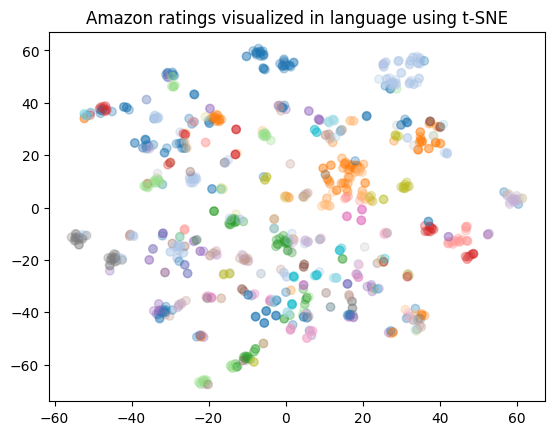

In [60]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

matrix = vectors

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = df.target_class.unique().tolist()

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

color_indices = df.target_class.apply(lambda x: colors.index(x))

colormap = matplotlib.cm.get_cmap('tab20', len(colors))

plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")

/tmp/ipykernel_284423/1360200364.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

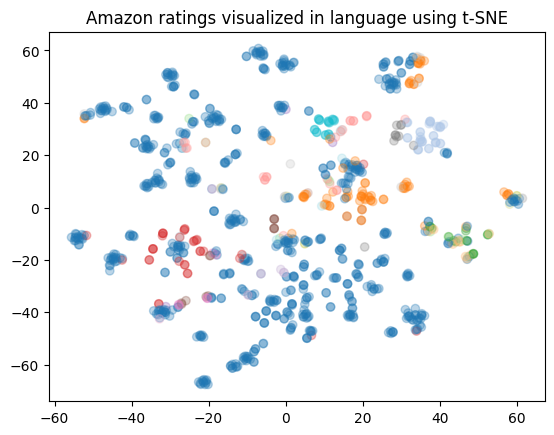

In [61]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

matrix = vectors

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = df.entity_class.unique().tolist()

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

color_indices = df.entity_class.apply(lambda x: colors.index(x))

colormap = matplotlib.cm.get_cmap('tab20', len(colors))

plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")

In [41]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(df.embedding.values)
n_clusters = 20

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['cluster'] = kmeans.labels_

In [42]:
df.cluster.value_counts()

cluster
14    127
10    104
5     100
2      99
16     55
8      54
7      51
19     47
4      44
0      41
9      38
6      38
3      36
15     32
11     29
1      27
18     25
17     25
13     19
12      9
Name: count, dtype: int64

In [53]:
for cluster in df.cluster.unique():
    print(f"Cluster {cluster}")
    print(df[df.cluster == cluster][['property_name', 'entity_class', 'target_class']])

Cluster 0
         property_name  entity_class  target_class
0      hasLoveInterest     Character        String
1          hasRelative     Character        String
8       affiliatedWith     Character     Character
11            hasChild     Character     Character
20         hasRelative     Character     Character
26     hasLoveInterest     Character     Character
27         hasRelative     Character     Character
37   relatedCharacters     Character     Character
43   relatedCharacters     Character     Character
44   hasMainMessengers     Character     Character
105           alliance     Character       Faction
143         playableAs     Character     Character
183           playable     Character     Character
196  belongsToAlliance     Character      Alliance
212  belongsToAlliance     Character      Alliance
215          hasAllies     Character     Character
216         hasEnemies     Character     Character
222        hasAlliance     Character      Alliance
241      notablePeopl

In [6]:
df = pd.read_sql_query(
    """
    SELECT
        embedding,
        cmetadata->>'property_id' as property_id,
        cmetadata->>'property_name' as property_name,
        cmetadata->>'property_description' as property_description,
        cmetadata->>'entity_class' as entity_class,
        cmetadata->>'entity_subclass' as entity_subclass,
        cmetadata->>'target_class' as target_class
    FROM langchain_pg_embedding WHERE collection_id = '9d70e7bc-099d-467c-a7e7-312345b411bd';
    """, conn)

/tmp/ipykernel_2610/2672257882.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [7]:
df['embedding'] = df.embedding.apply(eval).apply(np.array)
# convert df column with a vector to a numnpy 2d array
vectors = np.stack(df['embedding'].values)

In [62]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(df.embedding.values)
n_clusters = 400

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['cluster'] = kmeans.labels_

In [63]:
df.cluster.value_counts()

cluster
129    587
27     547
152    545
2      541
111    433
      ... 
89      20
258     19
297     15
79      13
278     12
Name: count, Length: 400, dtype: int64

### Batch Processing to merge clustered properties into a smaller list, find subproperties

#### Provide context OWL definitions

#### Structure output

In [13]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [126]:
import openai
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

openai.api_key = os.environ['OPENAI_APIKEY']
llm_model = "gpt-4o"
# llm_model = "gpt-4o-mini"
# llm_model = "chatgpt-4o-latest"


chat = ChatOpenAI(temperature=0.0, model=llm_model, openai_api_key=openai.api_key)

In [99]:
template_string_with_format = """
You are a highly skilled OWL (Web Ontology Language) ontology engineer. Your task is to assist in the creation, validation, and optimization of OWL ontologies, which are formal representations of knowledge. You have expert knowledge in knowledge engineering, description logic, and semantic web technologies. You also excel at defining classes, properties, and relationships between entities, ensuring logical consistency, and facilitating the sharing of knowledge across different domains.

An OWL ontology is a structured framework used to represent and share knowledge about a particular domain. It consists of classes (concepts), properties (relationships and attributes), and individuals (instances). OWL ontologies allow for the modeling of rich, complex relationships between data in a machine-readable format, enabling advanced reasoning, querying, and inference over that data.
Core OWL Concepts:

    Classes: These represent sets or collections of individuals, typically abstract concepts or types (e.g., "Character," "Weapon," "GameLevel").
    Individuals: Instances of classes (e.g., "Mario" is an individual of the class "Character"; "Sword of Flames" is an individual of the class "Weapon").
    Object Properties: Define relationships between two individuals (e.g., "wieldsWeapon" linking a character to a weapon they use, or "locatedIn" linking a character to a particular game level).
    Datatype Properties: Define relationships between an individual and a data value (e.g., "hasHealthPoints" linking a character to a numeric value representing their health).
    SubClassOf: A relation where one class is a subclass of another, inheriting properties (e.g., "BossCharacter" is a subclass of "Character").
    SubPropertyOf: A relation where one property is a subproperty of another, inheriting characteristics (e.g., "wieldsMagicWeapon" is a subproperty of "wieldsWeapon").
    Equivalence: Used to state that two classes or properties are equivalent (e.g., "MagicWeapon" may be declared equivalent to "SpecialWeapon").
    Disjoint Classes: These are classes that cannot share instances (e.g., "Weapon" and "ConsumableItem" are disjoint classes, meaning an item cannot be both a weapon and a consumable).

OWL Inference and Reasoning:

One of the powerful aspects of OWL is that it allows for reasoning over data. Inference engines can deduce new facts based on the relationships and properties defined in the ontology. For example, if "BossCharacter" is a subclass of "Character" and "Bowser" is an individual of "BossCharacter," it can be inferred that "Bowser" is also an individual of "Character." Additionally, if a property like "wieldsWeapon" is defined, you could infer that "Bowser wields a FireballWeapon" if such an individual and relationship are defined.

Your role is to take a list of closely related properties extracted from a large dataset of video games and to re-classify, rename \
and merge them into a more coherent and structured ontology. Some properties are repeated, some names are different versions of the same property, \
and some are logic parent or child of a property - forming a SubPropertyOf relatioship. Given the input list of properties, their id's, their names, descriptions, object class (entity_class), \
subject class (target_class), and subject subclass (entity_subclass), you are to re-organize them into a more coherent and structured ontology, \
with as few properties as possible, while maintaining the original meaning and relationships between the properties. Output no more than 20 aggregated properties.

The list of properties as dictionaries is as follows:
#####
{input_properties}
#####

{format_instructions}

"""

In [100]:
from typing import List, Union

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class Property(BaseModel):
    """Game Ontology Object or Data Property."""
    property_name: str = Field(..., description="Name of the property, for example: hasLocation, designedBy etc.")
    subject_class: str = Field(..., description="Class of the subject that the property is linking from. For example, if the property is linking from a character, the class is character. If the property is linking from a location, the class is location")
    object_class: str = Field(..., description="Class of the object that the property is linking to. For example, if the property is linking to a character, the class is Character. If the property is linking to a location, the class is Location If the property is linking to an item, the class is Item.")
    property_type: str = Field(..., description="The type of the property, either `object` or `data`. If propert points to object of some Class, the property type is object. If the property points to data, such as number, adate or a string, the property type is data.")
    description: str = Field(..., description="Description of the property, for example: The number of health points a character has, the number of attack points a character has, the number of defense points a character has, etc.")
    subPropertyOf: Union[str, None] = Field(..., description="The parent property that this property is a child of. Either infer the parent property from the given list properties, or create a new property that this property is a child of.")
    original_property_ids: List[int] = Field(..., description="List of original property_id's that have been merged into this property.")

class Properties(BaseModel):
    """List of Game Ontology Properties."""
    properties: List[Property]


# Set up a parser
output_parser = PydanticOutputParser(pydantic_object=Properties)
format_instructions = output_parser.get_format_instructions()

In [101]:
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"Property": {"description": "Game Ontology Object or Data Property.", "properties": {"property_name": {"description": "Name of the property, for example: hasLocation, designedBy etc.", "title": "Property Name", "type": "string"}, "subject_class": {"description": "Class of the subject that the property is linking from. For example, if the property is linking from a character, the class is character. If the property is linking from a location, the class is location", "title": "Subject Class", "type": "string"}, "object_class":

In [80]:
# get list of rows from df that have some cluster number
cluster = 129
# df[df.cluster == cluster].to_dict(orient='records')

In [81]:
input_properties = '\n'.join([
    # Given the input list of properties, their names, descriptions, object class (entity_class), subject class (target_class), and subject subclass (entity_subclass),
    f"'id': {row['property_id']}, 'name': {row['property_name']}, 'description': {row['property_description']}, 'subject_class': {row['entity_class']}, 'subject_subclass': {row['entity_subclass']}, 'object_class': {row['target_class']}" \
    for row in df[df.cluster == cluster].to_dict(orient='records')
])

In [82]:
input_properties

"'id': 7093, 'name': hasType, 'description': Indicates the type of character in the game, such as melee or ranged., 'subject_class': Character, 'subject_subclass': MeleeCharacter, 'object_class': Type\n'id': 7299, 'name': hasType, 'description': Represents the types associated with the Pokémon entity, indicating its elemental affinities., 'subject_class': Character, 'subject_subclass': Pokemon, 'object_class': Class\n'id': 7305, 'name': hasType, 'description': Indicates the type classification of the Pokémon., 'subject_class': Pokemon, 'subject_subclass': GroundTypePokemon, 'object_class': Type\n'id': 7326, 'name': hasSpecialistType, 'description': Represents the type of specialization the character has., 'subject_class': Character, 'subject_subclass': NPC, 'object_class': Specialization\n'id': 7340, 'name': hasType, 'description': The type of the Pokémon, determining its abilities and weaknesses., 'subject_class': Character, 'subject_subclass': Pokemon, 'object_class': Type\n'id': 734

In [83]:
prompt = ChatPromptTemplate.from_template(template=template_string_with_format)

messages = prompt.format_messages(input_properties=input_properties, 
                                format_instructions=format_instructions)

In [84]:
len(messages[0].content)

115396

In [86]:
response = chat(messages)

In [89]:
output_dict = output_parser.parse(response.content)

In [90]:
output_dict.properties

[Property(property_name='hasType', subject_class='Character', object_class='Class', property_type='object', description='Indicates the type classification of the character within the game.', subPropertyOf=None, original_property_ids=[29, 71, 81, 105, 1178, 3909, 3912, 6957, 7032, 7036, 7040, 7045, 7055, 7060, 7070, 7075, 7079, 7083, 7092, 7093, 7299, 7305, 7340, 7345, 7350, 8039, 8480, 8481, 8493, 8496, 8501, 8506, 8508, 8602, 9095, 9243, 10167, 10221, 10286, 10296, 10592, 10598, 10607, 10625, 10649, 10655, 10659, 10663, 10671, 10672, 10689, 10725, 13147, 13154, 13161, 11549, 11567, 11570, 11579, 11580, 11589, 11601, 11613, 11618, 11630, 11638, 11643, 11654, 11659, 11993, 12010, 12036, 12072, 12097, 12115, 12142, 12152, 12195, 12211, 12758, 13664, 13721, 13726, 13925, 14050, 14738, 14776, 15073, 15514, 15585, 15602, 16077, 16084, 16091, 16100, 16103, 16108, 16113, 16119, 16122, 16128, 16133, 16147, 16157, 16171, 16357, 16653, 16962, 17007, 17454, 17458, 17449, 18081, 18677, 18693, 1869

In [117]:
cur = conn2.cursor()

In [ ]:
for property in output_dict.properties:
    cur.execute(
        f"""
        INSERT INTO fandom_ontology_properties (property_name, description, subject_class, object_class, property_type, subPropertyOf, original_property_ids, cluster_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """,
        (property.property_name, property.description, property.subject_class, property.object_class, property.property_type, property.subPropertyOf, property.original_property_ids, cluster)
    )
    conn2.commit()

In [123]:
conn2.rollback()

In [ ]:
# create table fandom_ontology_properties (
#     id serial primary key,
#     property_name text,
#     description text,
#     subject_class text,
#     object_class text,
#     property_type text,
#     subPropertyOf text,
#     original_property_ids int[],
#     cluster_id int
# );

#### Run classifiers on all clusters, save to postgres

In [114]:
# save pairs of cluster_id and property_id to a csv file
df[['property_id', 'cluster']].to_csv('fandom_ontology_properties_clustered.csv', index=False)

In [167]:
df.cluster.value_counts()

cluster
129    587
27     547
152    545
2      541
111    433
      ... 
89      20
258     19
297     15
79      13
278     12
Name: count, Length: 400, dtype: int64

In [120]:
conn2 = pg.connect(
    dbname=os.environ["POSTGRES_DB"],
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"]
)
cur = conn2.cursor()

In [163]:
# batch_messages = []

for cluster in tqdm(df.cluster.unique()):

    cur.execute("SELECT COUNT(*) FROM fandom_ontology_properties WHERE cluster_id = %s", (int(cluster),))
    count = cur.fetchone()[0]
    if count > 0:
        # print(f"Skipping cluster {cluster} as it already has {count} properties")
        continue

    print(f"Cluster {cluster}")

    input_properties = '\n'.join([
        # Given the input list of properties, their names, descriptions, object class (entity_class), subject class (target_class), and subject subclass (entity_subclass),
        f"'id': {row['property_id']}, 'name': {row['property_name']}, 'description': {row['property_description']}, 'subject_class': {row['entity_class']}, 'subject_subclass': {row['entity_subclass']}, 'object_class': {row['target_class']}" \
        for row in df[df.cluster == cluster].to_dict(orient='records')
    ])
    prompt = ChatPromptTemplate.from_template(template=template_string_with_format)

    messages = prompt.format_messages(input_properties=input_properties, 
                                format_instructions=format_instructions)
    
    # batch_messages.append((messages, int(cluster)))
    
    response = chat(messages)
    output_dict = output_parser.parse(response.content)

    for property in output_dict.properties:
        cur.execute(
            f"""
            INSERT INTO fandom_ontology_properties (property_name, description, subject_class, object_class, property_type, subPropertyOf, original_property_ids, cluster_id)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """,
            (property.property_name, property.description, property.subject_class, property.object_class, property.property_type, property.subPropertyOf, property.original_property_ids, int(cluster))
        )
    conn2.commit()


  0%|          | 0/400 [00:00<?, ?it/s]

Cluster 221
Cluster 371
Cluster 269
Cluster 40
Cluster 339
Cluster 262
Cluster 309
Cluster 338
Cluster 324
Cluster 101
Cluster 373
Cluster 263
Cluster 385
Cluster 259
Cluster 306
Cluster 138
Cluster 198
Cluster 21
Cluster 207
Cluster 376
Cluster 274


In [131]:
conn2.rollback()

#### Create batch for OpenAI processing

In [143]:

batch_filename = f'batchinput_properties_clustered.jsonl'
with open(batch_filename, 'w') as f:
    for messages, cluster in batch_messages:

        request = {
            "custom_id": str(cluster),
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": [
                    {"role": "system", "content": messages[0].content}
                ]
            }
        }
        json.dump(request, f)
        f.write('\n')


In [144]:
from openai import OpenAI
client = OpenAI(api_key=os.environ['OPENAI_APIKEY'])

batch_input_file = client.files.create(
  file=open(batch_filename, "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

batch_create_msg = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": f"batch properties clustering job (partial)"
    }
)
batch_create_msg

Batch(id='batch_671a207112cc81908f55593e57e48ad6', completion_window='24h', created_at=1729765489, endpoint='/v1/chat/completions', input_file_id='file-iGoNvtWcmX5EsbfmoMWiumDS', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1729851889, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'batch properties clustering job (partial)'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [150]:
batch_info = client.batches.retrieve(batch_create_msg.id)
print(batch_info.metadata['description'], batch_info.status)
print(batch_info.request_counts)

batch properties clustering job (partial) in_progress
BatchRequestCounts(completed=221, failed=0, total=224)


In [146]:
batch_info

Batch(id='batch_671a207112cc81908f55593e57e48ad6', completion_window='24h', created_at=1729765489, endpoint='/v1/chat/completions', input_file_id='file-iGoNvtWcmX5EsbfmoMWiumDS', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1729851889, failed_at=None, finalizing_at=None, in_progress_at=1729765489, metadata={'description': 'batch properties clustering job (partial)'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=224))

In [151]:
batch_output_filename = f'batchoutput_properties_clustered.jsonl'
batch_status = client.batches.retrieve(batch_create_msg.id)
if batch_status.status == 'completed':
    file_response = client.files.content(batch_status.output_file_id)

    with open(batch_output_filename, "wb") as f:
        f.write(file_response.content)

    print(f"{batch_output_filename} completed.")
else:
    print(f"Batch job is still {batch_status.status}.")

batchoutput_properties_clustered.jsonl completed.


In [160]:
failed_ids = []
batch_data = []
with open(batch_output_filename, "r") as f:
    for line in f:
        batch_data.append(json.loads(line))

output_dicts = []
for response in tqdm(batch_data):
    content = response['response']['body']['choices'][0]['message']['content']
    try:
        properties = output_parser.parse(content)
        for property in properties.properties:
            prop = property.model_dump()
            prop['cluster_id'] = response['custom_id']

            output_dicts.append(prop)
    except Exception as e:

        # print(e)
        # print("Failed object_id:", response['custom_id'])
        print(response['custom_id'])
        failed_ids.append(response['custom_id'])

  0%|          | 0/224 [00:00<?, ?it/s]

221
371
269
40
339
262
309
338
324
101
373
263
385
259
306
138
198
21
207
376
274


In [161]:
len(output_dicts)

2006

In [162]:
# write data to the database
cur = conn2.cursor()

for prop in tqdm(output_dicts):
    cur.execute(
        f"""
        INSERT INTO fandom_ontology_properties (property_name, description, subject_class, object_class, property_type, subPropertyOf, original_property_ids, cluster_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """,
        (prop['property_name'], prop['description'], prop['subject_class'], prop['object_class'], prop['property_type'], prop['subPropertyOf'], prop['original_property_ids'], prop['cluster_id'])
    )
    conn2.commit()


NameError: name 'conn2' is not defined

#### Query vector store using similarity search

In [ ]:
query = "property of a game that describes the developer/designer of the game"

results = vector_store.similarity_search_with_score(
    query=query,
    k=50,
    filter={
        "entity_class": {"$in": ['Game']},
        # "target_class": {"$in": ['Location', 'City']}
    }
)
for doc in results:
    print(f"* {doc[1]} {doc[0].page_content} [{doc[0].metadata}]")

#### Vizualize property embeddings projected on a 2D map, by class

In [44]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = matrix

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/aleksey/Workspace/GameOntologyProject/venv/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [59]:
df_plotly = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "class": row["entity_class"],
            "extract": row['property_description'][:100],
            "symbol": "circle",
            "size_col": 10,
        }
        for i, row in enumerate(df.to_dict(orient="records"))
    ]
)

# Visualize the embedding
fig = px.scatter(
    df_plotly,
    x="x",
    y="y",
    color="class",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1800,
    height=1000,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Property Embeddings via PaCMAP</b>",
)
fig.show()